1. IMPORTAÇÕES E CARREGAMENTO DOS DADOS

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

movies = pd.read_csv("../data/movies.csv")

# Carregando só 1 milhão de linhas do ratings (ou menos, se necessário)
ratings = pd.read_csv("../data/ratings.csv", nrows=1000000)

df = ratings.merge(movies, on="movieId", how="left")
df.head()


2. ENTENDIMENTO INICIAL DO DATASET


In [ ]:
df.info()
df.describe()

In [ ]:
print("Total de filmes:", movies.shape)
print("Total de avaliações:", ratings.shape)
print("Período das avaliações:")
print("Min:", df['timestamp'].min())
print("Max:", df['timestamp'].max())


3. VERIFICAÇÃO DE DADOS FALTANTES

In [ ]:
df.isna().sum()

4. PROCESSAMENTO E VERIFICAÇÃO DE CONSISTÊNCIA

In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df["year"] = df["timestamp"].dt.year

In [ ]:
# Cria uma coluna com lista de gêneros
movies["genres_list"] = movies["genres"].apply(lambda x: x.split("|"))

In [ ]:
df.duplicated(subset=["userId", "movieId"]).sum()

5. ESTATÍSTICAS GERAIS

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["rating"], bins=10, kde=True)
plt.title("Distribuição das Avaliações")
plt.xlabel("Nota")
plt.show()

In [ ]:
avaliacoes_por_filme = df["title"].value_counts()
avaliacoes_por_filme.head()


6. PERGUNTAS

Pergunta 1 — Quais são os filmes mais bem avaliados?

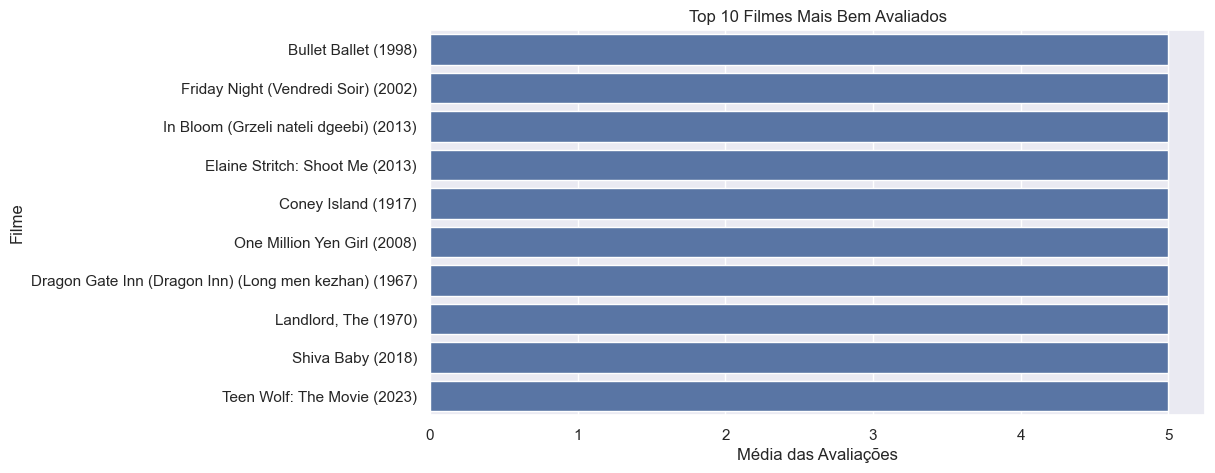

In [100]:
media_por_filme = df.groupby(["movieId", "title"])["rating"].mean().reset_index()
top10 = media_por_filme.sort_values("rating", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x="rating", y="title")
plt.title("Top 10 Filmes Mais Bem Avaliados")
plt.xlabel("Média das Avaliações")
plt.ylabel("Filme")
plt.show()


Pergunta 2 — Quais filmes têm mais avaliações (populares)?

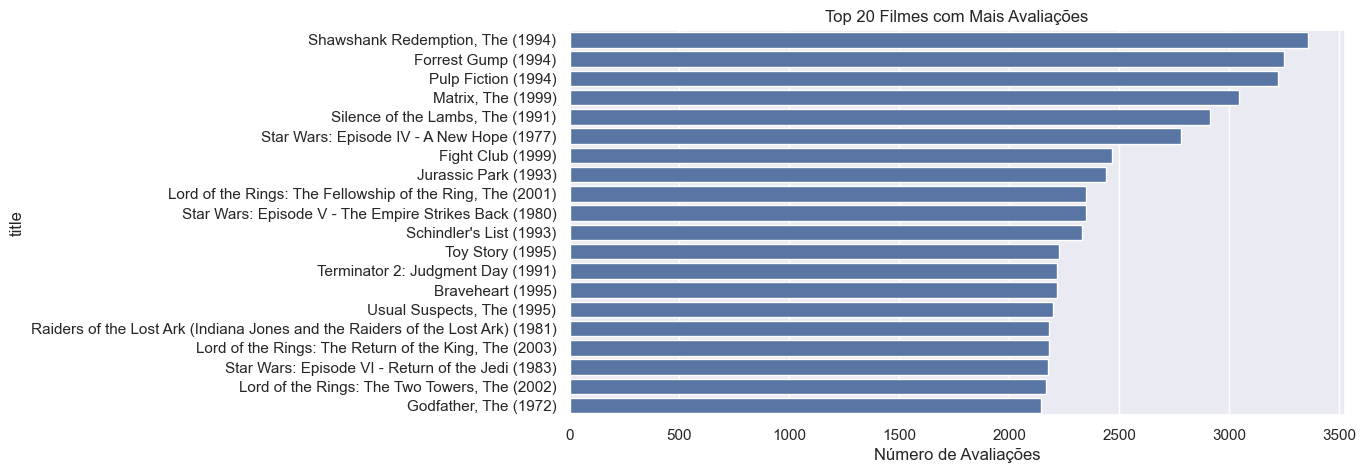

In [101]:
popularidade = df["title"].value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=popularidade.values, y=popularidade.index)
plt.title("Top 20 Filmes com Mais Avaliações")
plt.xlabel("Número de Avaliações")
plt.show()


Pergunta 3 — Distribuição das Notas por Ano

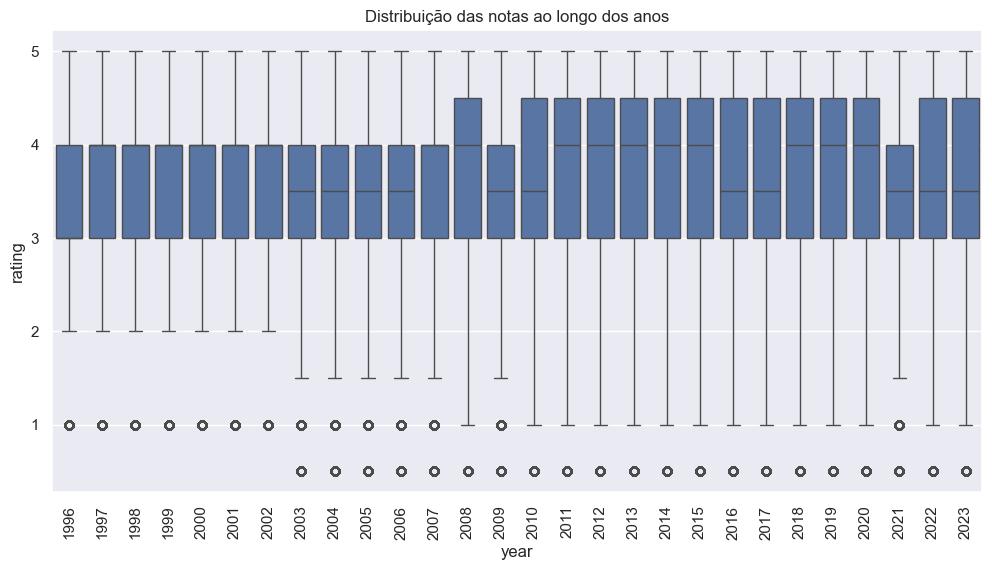

In [102]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="year", y="rating")
plt.xticks(rotation=90)
plt.title("Distribuição das notas ao longo dos anos")
plt.show()

Pergunta 4 — Quais gêneros são mais populares?

In [103]:
from collections import Counter

todos_generos = Counter()
movies["genres_list"].apply(todos_generos.update)

generos_df = pd.DataFrame.from_dict(todos_generos, orient="index", columns=["count"])
generos_df = generos_df.sort_values("count", ascending=False)
print(generos_df)


                    count
Drama               34175
Comedy              23124
Thriller            11823
Romance             10369
Action               9668
Documentary          9363
Horror               8654
(no genres listed)   7080
Crime                6976
Adventure            5402
Sci-Fi               4907
Animation            4617
Children             4520
Mystery              4013
Fantasy              3851
War                  2325
Western              1696
Musical              1059
Film-Noir             353
IMAX                  195


Pergunta 5 - Padrão de avaliação dos usuários (alguém é mais crítico?)

Usuários Mais Críticos (Menor Nota Média):
      userId      mean       std  count
5332    5333  0.500000  0.000000     20
5695    5696  1.000000  0.000000     20
3143    3144  1.140000  1.055936     25
5472    5473  1.140000  1.380821     25
1078    1079  1.209459  0.917885     74
6212    6213  1.294574  0.977594    258
555      556  1.301609  1.127991    373
3196    3197  1.329240  1.177999   1751
6075    6076  1.383523  1.525869    352
1108    1109  1.500000  1.063757     20

Usuários Mais Generosos (Maior Nota Média):
      userId      mean       std  count
1912    1913  5.000000  0.000000     50
2311    2312  5.000000  0.000000     38
2581    2582  5.000000  0.000000     21
3041    3042  5.000000  0.000000     20
3496    3497  5.000000  0.000000     29
3802    3803  5.000000  0.000000     35
4122    4123  5.000000  0.000000    103
4152    4153  5.000000  0.000000     34
4163    4164  5.000000  0.000000     20
2766    2767  4.997389  0.036084    383

Usuários Mais Consistentes (Men

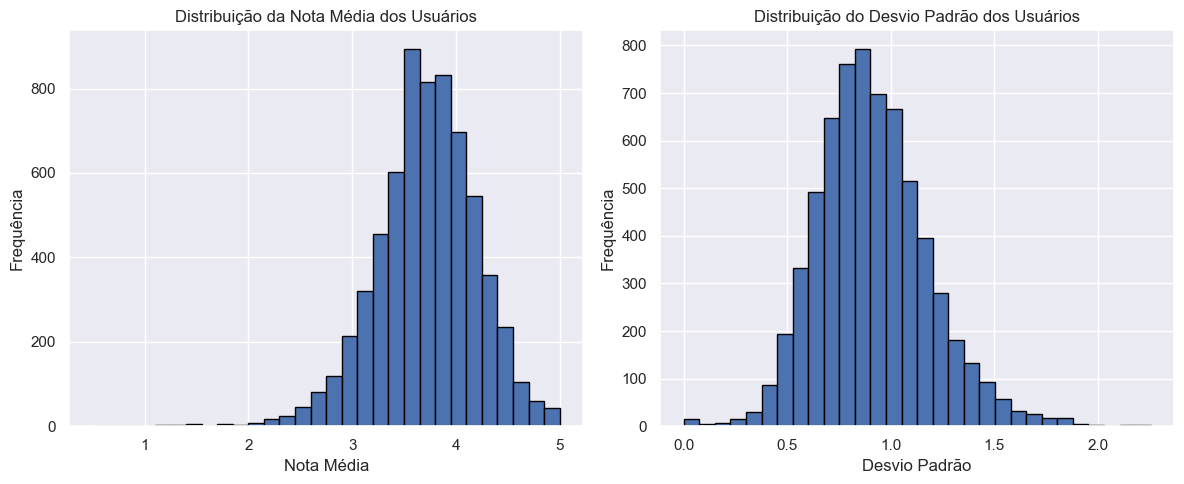

In [105]:
# Estatísticas de usuários
usuario_stats = df.groupby('userId')['rating'].agg(['mean', 'std', 'count']).reset_index()
usuario_stats = usuario_stats[usuario_stats['count'] >= 20]  # Usuários com 20+ avaliações

print("Usuários Mais Críticos (Menor Nota Média):")
print(usuario_stats.nsmallest(10, 'mean'))

print("\nUsuários Mais Generosos (Maior Nota Média):")
print(usuario_stats.nlargest(10, 'mean'))

print("\nUsuários Mais Consistentes (Menor Desvio Padrão):")
print(usuario_stats.nsmallest(10, 'std'))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(usuario_stats['mean'], bins=30, edgecolor='black')
plt.title("Distribuição da Nota Média dos Usuários")
plt.xlabel("Nota Média")
plt.ylabel("Frequência")

plt.subplot(1,2,2)
plt.hist(usuario_stats['std'], bins=30, edgecolor='black')
plt.title("Distribuição do Desvio Padrão dos Usuários")
plt.xlabel("Desvio Padrão")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

Pergunta 6 - Qual é a nota mais comum (moda) para cada filme?

Exemplos de Filmes e suas Modas:
                                        title      mean  moda  count
0            "Great Performances" Cats (1998)  3.000000   4.0      7
1                  #1 Cheerleader Camp (2010)  2.500000   1.0      2
2                               #Alive (2020)  3.600000   3.5      5
3                              #Horror (2015)  1.750000   1.5      2
4                             $5 a Day (2008)  0.500000   0.5      1
5                                  '71 (2014)  3.675000   3.0     20
6                                  '77 (2007)  3.500000   3.5      1
7     'Hellboy': The Seeds of Creation (2004)  2.250000   0.5      4
8                              'R Xmas (2001)  3.500000   3.5      1
9                      'Round Midnight (1986)  3.857143   3.5      7
10                        'Salem's Lot (2004)  3.250000   2.0      4
11                  'Til There Was You (1997)  3.000000   3.0     16
12    'Twas the Night Before Christmas (1974)  3.500000   3.5      1
1

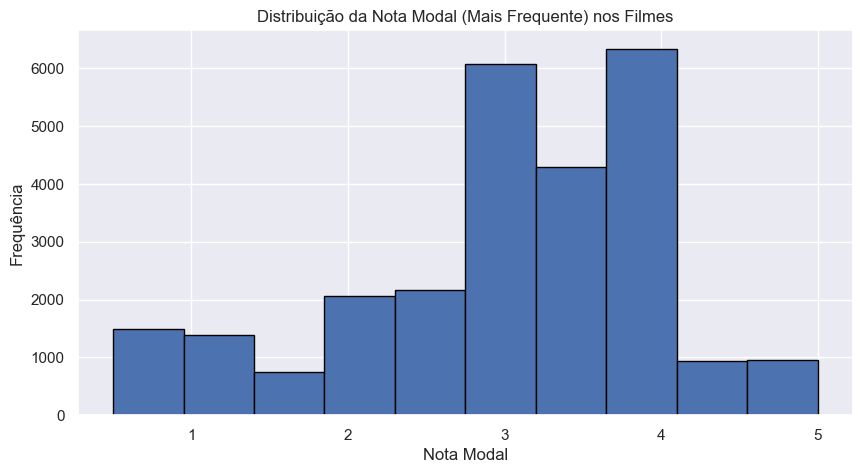

In [109]:
from scipy import stats

# Calcular estatísticas dos filmes se ainda não foi feito
filme_stats = df.groupby('title')['rating'].agg(['mean', 'std', 'count']).reset_index()

# Moda das notas por filme
filme_moda = df.groupby('title')['rating'].apply(lambda x: stats.mode(x, keepdims=True).mode[0]).reset_index()
filme_moda.columns = ['title', 'moda']

# Correlação entre moda e média
filme_stats_moda = filme_stats.merge(filme_moda, on='title', how='left')

print("Exemplos de Filmes e suas Modas:")
print(filme_stats_moda[['title', 'mean', 'moda', 'count']].head(20))

# Distribuição das modas
plt.figure(figsize=(10,5))
plt.hist(filme_moda['moda'].dropna(), bins=10, edgecolor='black')
plt.title("Distribuição da Nota Modal (Mais Frequente) nos Filmes")
plt.xlabel("Nota Modal")
plt.ylabel("Frequência")
plt.show()

Pergunta 7 — Filmes com mais gêneros têm notas diferentes?

Nota Média por Quantidade de Gêneros:
   num_genres      mean       std   count
0           1  3.512376  1.067979  161684
1           2  3.565257  1.065833  279287
2           3  3.590057  1.043507  317431
3           4  3.560942  1.055730  168373
4           5  3.569982  1.039455   55864
5           6  3.602641  1.041566   13479
6           7  3.869565  0.969875    3864
7           8  5.000000       NaN       1
8          10  3.088235  1.202020      17


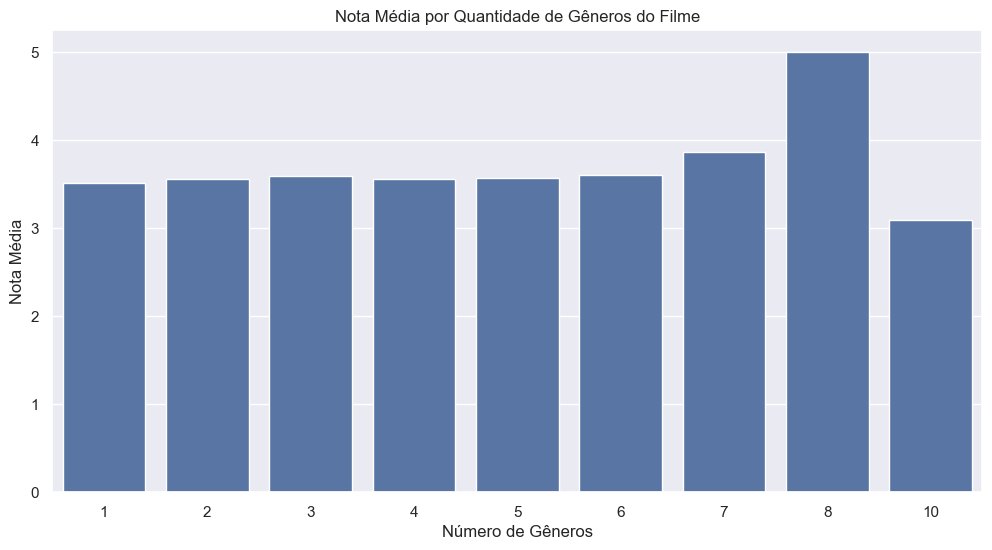

In [110]:
# Número de gêneros por filme
# df já tem a coluna 'genres', então podemos usar diretamente
df['num_genres'] = df['genres'].str.split('|').str.len()

media_por_num_generos = df.groupby('num_genres')['rating'].agg(['mean', 'std', 'count']).reset_index()

print("Nota Média por Quantidade de Gêneros:")
print(media_por_num_generos)

plt.figure(figsize=(12,6))
sns.barplot(data=media_por_num_generos, x='num_genres', y='mean')
plt.title("Nota Média por Quantidade de Gêneros do Filme")
plt.xlabel("Número de Gêneros")
plt.ylabel("Nota Média")
plt.show()

Pergunta 8 — Qual é o filme mais unanimemente bom?

Top 20 Filmes com Maior Consenso (Baixa Variabilidade + Nota Alta):
                                  title      mean       std  count
7187        Escape from Alcatraz (1979)  3.865741  0.609912    108
9839          Hell or High Water (2016)  3.958678  0.666417    121
10534             Hurricane, The (1999)  3.967153  0.670284    137
13886  Man Who Wasn't There, The (2001)  3.878125  0.676996    160
7069                End of Watch (2012)  3.842593  0.678950    108
14154             Matchstick Men (2003)  3.731915  0.690629    235
17147               Planet Earth (2006)  4.447115  0.696448    104
14654        Mississippi Burning (1988)  3.850993  0.697124    151
18699               Runaway Jury (2003)  3.686207  0.702043    145
4560              Cinderella Man (2005)  3.887665  0.703611    227
22850              The Nice Guys (2016)  3.885638  0.706317    188
10808                   Identity (2003)  3.673152  0.709987    257
14823                       Moon (2009)  4.060491  0.712529  

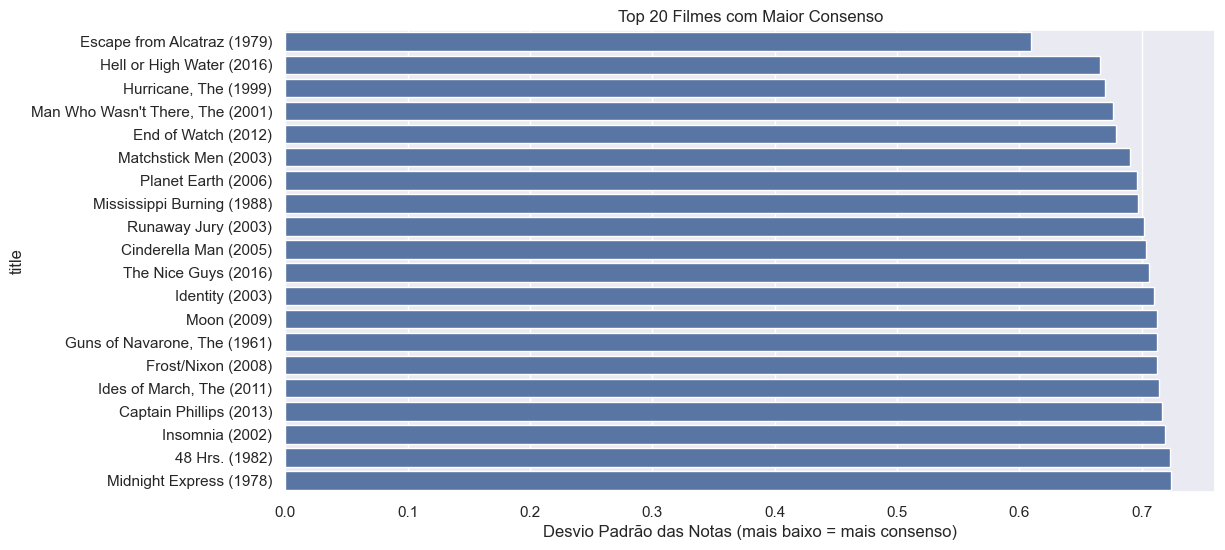

In [115]:
# Filmes com consenso (baixa variabilidade + nota alta + muitas avaliações)
filme_stats_consenso = filme_stats[filme_stats['count'] >= 100].copy()
filme_stats_consenso = filme_stats_consenso.sort_values('std', ascending=True)

print("Top 20 Filmes com Maior Consenso (Baixa Variabilidade + Nota Alta):")
print(filme_stats_consenso[filme_stats_consenso['mean'] >= 3.5].head(20))

plt.figure(figsize=(12,6))
sns.barplot(data=filme_stats_consenso[filme_stats_consenso['mean'] >= 3.5].head(20), x='std', y='title')
plt.title("Top 20 Filmes com Maior Consenso")
plt.xlabel("Desvio Padrão das Notas (mais baixo = mais consenso)")
plt.show()

Pergunta 9 — Qual gênero é mais "divisivo" (maior variabilidade)?

Top 20 Filmes Mais Divisivos (Desvio Padrão Alto):
                                                   title      mean       std  \
17139                     Plan 9 from Outer Space (1959)  2.644737  1.568047   
9486                                     Hamilton (2020)  3.460000  1.514690   
24521  Twilight Saga: Breaking Dawn - Part 2, The (2012)  2.397260  1.499905   
24523                Twilight Saga: New Moon, The (2009)  2.338710  1.476852   
24520  Twilight Saga: Breaking Dawn - Part 1, The (2011)  2.333333  1.461981   
13368                       Louis C.K.: Shameless (2007)  3.583333  1.453334   
13364                       Louis C.K.: Chewed Up (2008)  3.689655  1.450431   
24522                 Twilight Saga: Eclipse, The (2010)  2.381890  1.442629   
19363                            Sex and the City (2008)  2.812500  1.441010   
26205                                    Year One (2009)  2.470000  1.397556   
8746                                 Ghostbusters (2016)  2.746479  1

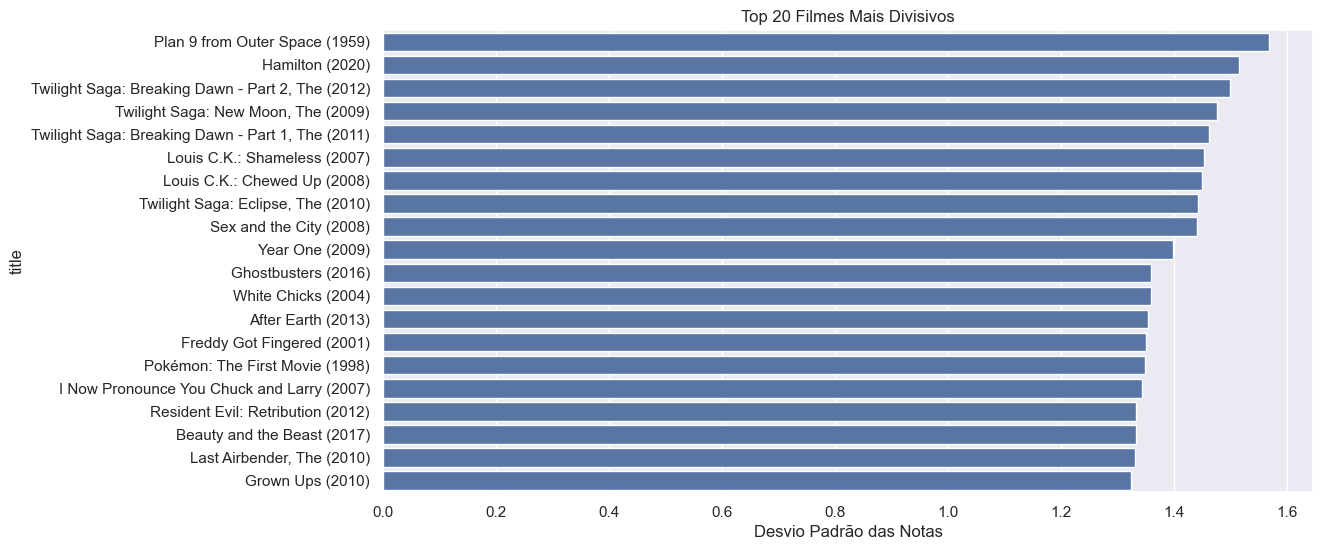

In [117]:
# Filmes mais divisivos (alta variabilidade, muitas avaliações)
filme_stats = df.groupby('title')['rating'].agg(['mean', 'std', 'count']).reset_index()
filme_stats = filme_stats[filme_stats['count'] >= 50]  # Apenas filmes com 50+ avaliações
filme_stats = filme_stats.sort_values('std', ascending=False)

print("Top 20 Filmes Mais Divisivos (Desvio Padrão Alto):")
print(filme_stats.head(20))

plt.figure(figsize=(12,6))
sns.barplot(data=filme_stats.head(20), x='std', y='title')
plt.title("Top 20 Filmes Mais Divisivos")
plt.xlabel("Desvio Padrão das Notas")
plt.show()

Pergunta 10 — Qual gênero tem a maior nota média?

Média de Notas por Gênero:
                        mean   count       std
genre                                         
Film-Noir           3.944662    9207  0.891036
War                 3.818717   49704  0.981237
Documentary         3.720320   12997  1.020748
Crime               3.718701  170372  0.998002
Drama               3.707800  435648  0.990418
Mystery             3.696186   82218  1.002211
Animation           3.636438   68196  1.022206
Western             3.633893   18033  0.999888
IMAX                3.618537   47732  1.058257
Musical             3.593011   35286  1.047514
Romance             3.568280  171544  1.042269
Thriller            3.558298  275429  1.033740
Adventure           3.551877  239661  1.064018
Fantasy             3.533847  115475  1.086619
Sci-Fi              3.516700  182667  1.088370
Action              3.507053  307753  1.068510
Children            3.467667   83567  1.078774
Comedy              3.454603  349385  1.076333
(no genres listed)  3.333435    1

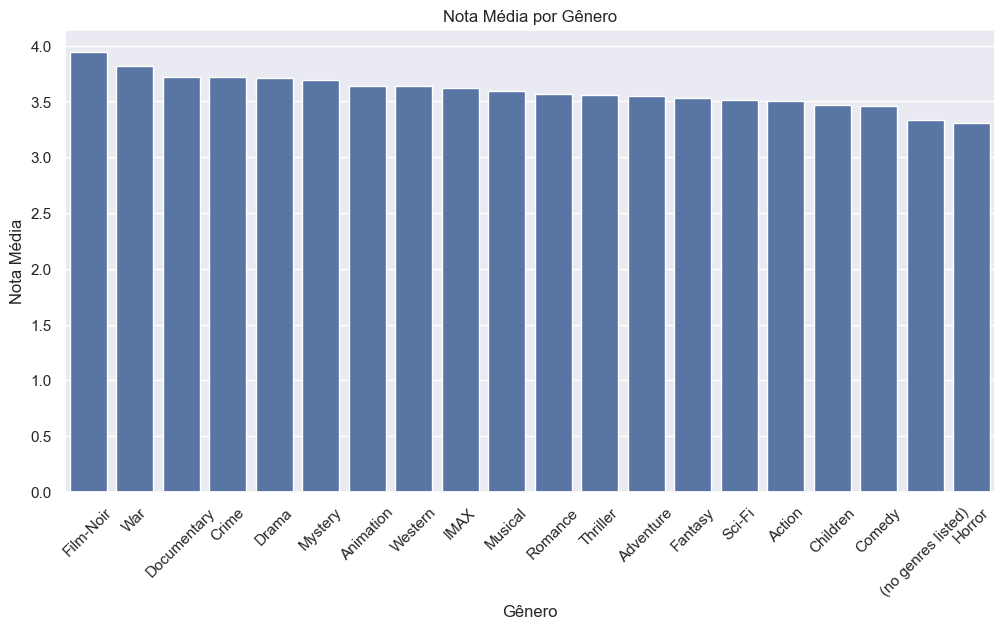

In [118]:
# Explodindo a coluna de gêneros para analisar cada um
df_generos = df.copy()
df_generos['genre'] = df_generos['genres'].str.split('|')
df_generos = df_generos.explode('genre')

# Média de notas por gênero
media_generos = df_generos.groupby('genre')['rating'].agg(['mean', 'count', 'std']).sort_values('mean', ascending=False)
print("Média de Notas por Gênero:")
print(media_generos)

plt.figure(figsize=(12,6))
sns.barplot(data=media_generos.reset_index(), x='genre', y='mean')
plt.title("Nota Média por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Nota Média")
plt.xticks(rotation=45)
plt.show()

Pergunta 11 — Correlação entre gêneros (quais gêneros aparecem juntos nos melhores filmes?)

Combinações de Gêneros Mais Comuns em Filmes Bem Avaliados (>=4.0):
(Action, Drama)           57
(Drama, Romance)          56
(Comedy, Drama)           54
(Action, Adventure)       52
(Drama, Thriller)         47
(Adventure, Drama)        47
(Adventure, Fantasy)      42
(Crime, Drama)            42
(Drama, Fantasy)          41
(Drama, Mystery)          40
(Crime, Thriller)         40
(Adventure, Animation)    38
(Action, Animation)       38
(Adventure, Comedy)       36
(Comedy, Romance)         36
Name: count, dtype: int64


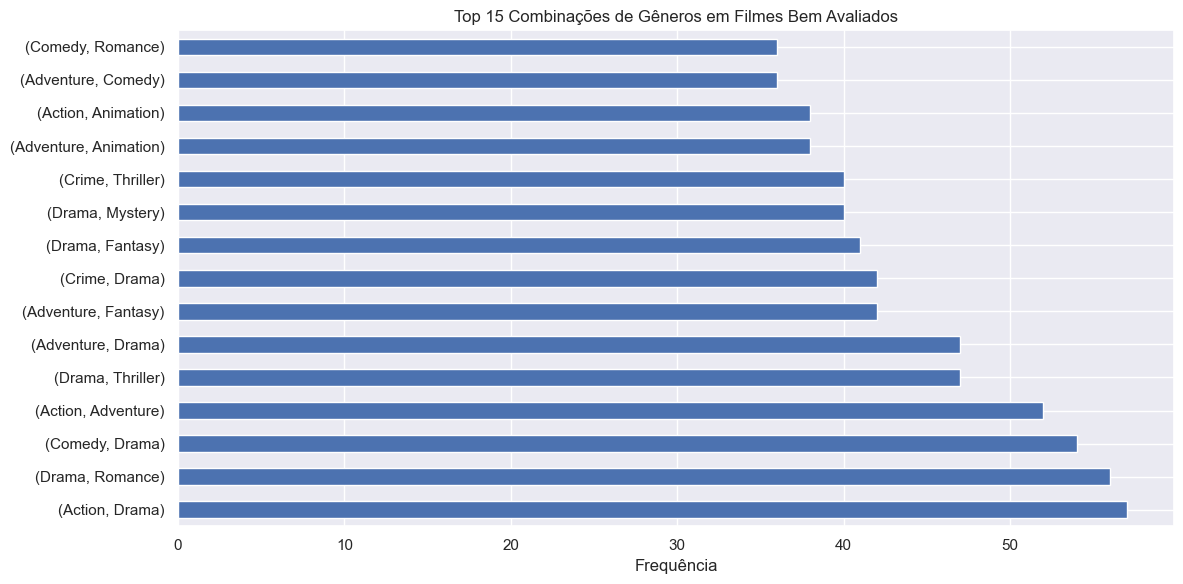

In [119]:
# Combinar gêneros em filmes bem avaliados
df_top_rated = df[df.groupby('title')['rating'].transform('mean') >= 4.0].copy()

# Criando matriz de correlação entre gêneros
from itertools import combinations

genero_pairs = []
for genres_str in df_top_rated['genres'].unique():
    if pd.notna(genres_str):
        genres_list = genres_str.split('|')
        if len(genres_list) > 1:
            for pair in combinations(sorted(genres_list), 2):
                genero_pairs.append(pair)

genero_pairs_count = pd.Series(genero_pairs).value_counts().head(15)

print("Combinações de Gêneros Mais Comuns em Filmes Bem Avaliados (>=4.0):")
print(genero_pairs_count)

plt.figure(figsize=(12,6))
genero_pairs_count.plot(kind='barh')
plt.title("Top 15 Combinações de Gêneros em Filmes Bem Avaliados")
plt.xlabel("Frequência")
plt.tight_layout()
plt.show()

Pergunta 12 — Filmes mais bem avaliados por ano

Melhor Filme por Ano:
       year_release                                              title  \
12826        2004.0                               Riding Giants (2004)   
13261        2005.0               Joyeux Noël (Merry Christmas) (2005)   
14032        2006.0                                Planet Earth (2006)   
14580        2007.0                   In the Shadow of the Moon (2007)   
15262        2008.0   House of Small Cubes, The (Tsumiki no ie) (2008)   
15998        2009.0                                        Home (2009)   
16750        2010.0                                   Inception (2010)   
17212        2011.0  All Watched Over by Machines of Loving Grace (...   
18399        2012.0                                    Paperman (2012)   
18845        2013.0  Dance of Reality, The (Danza de la realidad, L...   
19767        2014.0                               Force Majeure (2014)   
21094        2015.0                       The Boy and the Beast (2015)   
21811        201

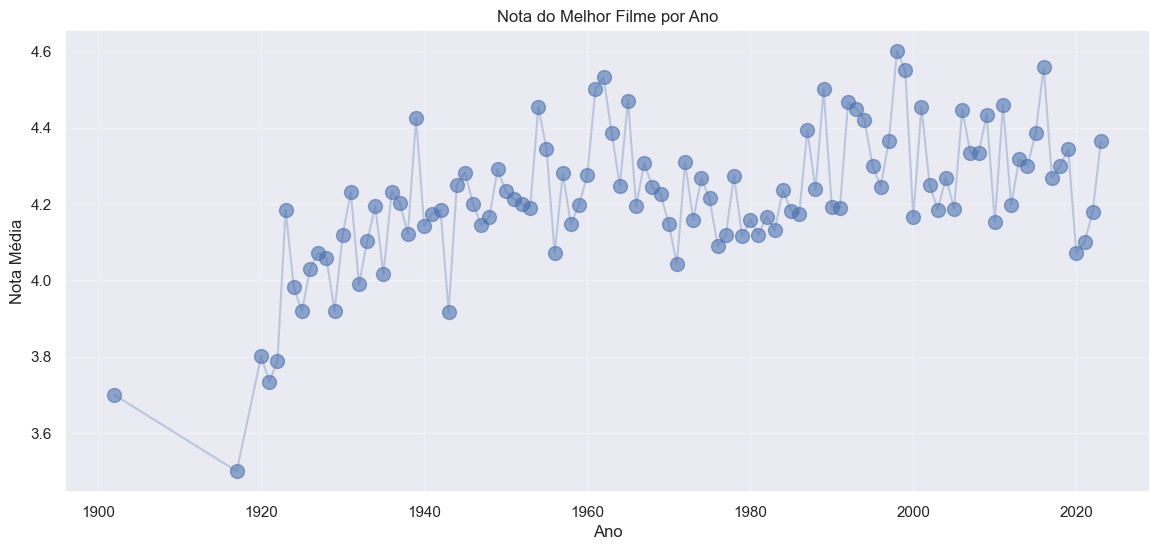

In [ ]:
# Encontrar o melhor filme de cada ano (com mínimo de avaliações)
df['year_release'] = df['title'].str.extract(r'\((\d{4})\)$')
df['year_release'] = pd.to_numeric(df['year_release'], errors='coerce')

filme_por_ano = df.groupby(['year_release', 'title'])['rating'].agg(['mean', 'count']).reset_index()
filme_por_ano = filme_por_ano[filme_por_ano['count'] >= 10]  # Mínimo de 10 avaliações

# Top filme por ano
melhor_filme_por_ano = filme_por_ano.loc[filme_por_ano.groupby('year_release')['mean'].idxmax()]
melhor_filme_por_ano = melhor_filme_por_ano.sort_values('year_release')

print("Melhor Filme por Ano:")
print(melhor_filme_por_ano[['year_release', 'title', 'mean', 'count']].tail(20))

# Gráfico com barras mostrando a nota do melhor filme por ano
plt.figure(figsize=(16,7))

# Filtrar apenas anos com dados válidos
melhor_por_ano_valid = melhor_filme_por_ano.dropna(subset=['year_release'])
melhor_por_ano_valid = melhor_por_ano_valid[melhor_por_ano_valid['year_release'] >= 1980]

# Gráfico de barras com linha de tendência
ax = plt.gca()
bars = ax.bar(melhor_por_ano_valid['year_release'], melhor_por_ano_valid['mean'], 
              width=0.8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)

# Linha de tendência
ax.plot(melhor_por_ano_valid['year_release'], melhor_por_ano_valid['mean'], 
        color='red', linewidth=2, marker='o', markersize=6, alpha=0.8, label='Tendência')

# Adicionar valores nas barras
for i, (year, rating) in enumerate(zip(melhor_por_ano_valid['year_release'], melhor_por_ano_valid['mean'])):
    ax.text(year, rating + 0.05, f'{rating:.2f}', ha='center', va='bottom', fontsize=8)

plt.title("Nota do Melhor Filme por Ano", fontsize=14, fontweight='bold')
plt.xlabel("Ano de Lançamento", fontsize=12)
plt.ylabel("Nota Média do Melhor Filme", fontsize=12)
plt.ylim(0, 5.5)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()